In [ ]:
import sys
import os

try:
    lib_path = os.path.abspath(os.path.join(os.path.dirname(__file__), '..', 'lib'))
except NameError:
    lib_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'lib'))

sys.path.insert(0, lib_path)

from KMeans import KMeansClusterization
from KMedians import KMediansClusterization
from HierarchicalClustering import HierarchicalClusteringClusterization
from HierarchicalClustering import HierarchicalClusteringClusterization
from NearestNeighbor import NearestNeighborClusterization
from DBSCAN import DBSCANClusterization

In [ ]:
import numpy as np
from sklearn.datasets import make_blobs, make_circles

def generate_sample_data(n_samples=300):
    """Генерація тестових даних"""
    np.random.seed(42)
    X1, _ = make_blobs(n_samples, centers=4, cluster_std=0.8, random_state=42)
    X2, _ = make_circles(n_samples, noise=0.1, factor=0.3, random_state=42)
    X3 = np.random.randn(200, 2) * 2
    outliers = np.random.randn(20, 2) * 8 + 10
    X3 = np.vstack([X3, outliers])

    return X1, X2, X3

In [ ]:
def demonstrate_kmeans():
    """Демонстрація K-Means"""
    print("\n=== K-Means ===")
    X, _, _ = generate_sample_data()
    
    kmeans = KMeansClusterization(k=4, random_state=42)
    labels = kmeans.fit_predict(X)
    
    print(f"Кількість кластерів: {kmeans.k}")
    print(f"Центроїди:\n{kmeans.get_centroids()}")
    
    kmeans.visualize(X, "K-Means Example")

In [ ]:
def demonstrate_kmedians():
    """Демонстрація K-Medians"""
    print("\n=== K-Medians ===")
    X, _, _ = generate_sample_data()
    
    kmedians = KMediansClusterization(k=4, random_state=42)
    labels = kmedians.fit_predict(X)
    
    print(f"Кількість кластерів: {kmedians.k}")
    print(f"Медіани:\n{kmedians.get_medians()}")
    
    kmedians.visualize(X, "K-Medians Example")

In [ ]:
def demonstrate_hierarchical():
    """Демонстрація ієрархічної кластеризації"""
    print("\n=== Hierarchical Clustering ===")
    X, _, _ = generate_sample_data()
    
    hierarchical = HierarchicalClusteringClusterization(linkage='single')
    hierarchical.fit(X)
    
    print("Побудована дендрограма")
    
    hierarchical.visualize_dendrogram("Hierarchical Clustering Dendrogram")
    
    # Візуалізація кластерів
    hierarchical.visualize_clusters(X, n_clusters=4, title="Hierarchical Clustering (4 clusters)")

In [ ]:
def demonstrate_nearest_neighbor():
    """Демонстрація алгоритму найближчого сусіда"""
    print("\n=== Nearest Neighbor ===")
    X, _, _ = generate_sample_data()
    
    nn = NearestNeighborClusterization(n_neighbors=5)
    
    query_point = np.array([2, 2])
    neighbors = nn.get_neighbors(query_point, X)
    print(f"Найближчі сусіди для точки {query_point}:")
    for i, (idx, dist) in enumerate(neighbors):
        print(f"  {i+1}. Індекс: {idx}, Відстань: {dist:.3f}")
    
    nn.visualize_neighbors(query_point, X, "Nearest Neighbors Example")
    
    labels = nn.fit_predict_clustering(X, threshold=1.5)
    print(f"Знайдено {len(np.unique(labels))} кластерів")
    
    nn.visualize_clustering(X, "Nearest Neighbor Clustering")

In [ ]:
def demonstrate_dbscan():
    """Демонстрація DBSCAN"""
    print("\n=== DBSCAN ===")
    _, X_circles, X_outliers = generate_sample_data()

    dbscan_circles = DBSCANClusterization(eps=0.3, min_samples=10)
    labels_circles = dbscan_circles.fit_predict(X_circles)
    
    info = dbscan_circles.get_cluster_info()
    print("Результати для кільцевих даних:")
    print(f"Кількість кластерів: {info['n_clusters']}")
    print(f"Кількість шумових точок: {info['n_noise_points']}")
    print(f"Розміри кластерів: {info['cluster_sizes']}")
    
    dbscan_circles.visualize(X_circles, "DBSCAN - Circular Data")

    dbscan_outliers = DBSCANClusterization(eps=1.0, min_samples=5)
    labels_outliers = dbscan_outliers.fit_predict(X_outliers)
    
    info = dbscan_outliers.get_cluster_info()

    print("\nРезультати для даних з викидами:")
    print(f"Кількість кластерів: {info['n_clusters']}")
    print(f"Кількість шумових точок: {info['n_noise_points']}")
    print(f"Розміри кластерів: {info['cluster_sizes']}")
    
    dbscan_outliers.visualize(X_outliers, "DBSCAN - Data with Outliers")

In [ ]:
demonstrate_kmeans()
demonstrate_kmedians()
demonstrate_hierarchical()
demonstrate_nearest_neighbor()
demonstrate_dbscan()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.metrics import adjusted_rand_score, silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

def get_labels_from_model(model, algo_name, X):
    if "own" in algo_name and "Hierarchical" in algo_name:
        model.fit(X)
        labels = model.get_clusters(4, X)  # власний метод
    elif "Nearest" in algo_name:
        labels = model.fit_predict_clustering(X, threshold=1.2)  # власний метод
    elif hasattr(model, 'fit_predict'):
        labels = model.fit_predict(X)
    else:
        model.fit(X)
        labels = getattr(model, 'labels_', None)
        if labels is None:
            raise AttributeError(f"Модель '{algo_name}' не має атрибута 'labels_' після fit()")
    return labels

def compare_and_plot_all(n_samples=1000, scale_factor=1.0):
    datasets = {
        "Blobs": lambda: make_blobs(n_samples=n_samples, centers=4, cluster_std=0.8, random_state=42),
        "Moons": lambda: make_moons(n_samples=n_samples, noise=0.07, random_state=42),
        "Circles": lambda: make_circles(n_samples=n_samples, noise=0.07, factor=0.5, random_state=42),
        "Anisotropic Blobs": lambda: anisotropic_blobs(n_samples),
        "Varied Variance Blobs": lambda: varied_variance_blobs(n_samples),
        "Noisy Blobs": lambda: noisy_blobs(n_samples),
        "Uniform Random": lambda: (np.random.rand(n_samples, 2), np.zeros(n_samples)),
        "No Structure": lambda: (np.random.rand(n_samples, 2), np.zeros(n_samples)),
    }

    algorithms = {
        "K-Means (own)": lambda: KMeansClusterization(k=4, random_state=42),
        "K-Means (sklearn)": lambda: KMeans(n_clusters=4, random_state=42),

        "K-Medians (own)": lambda: KMediansClusterization(k=4, random_state=42),
        # "K-Medoids (sklearn-extra)": lambda: KMedoids(n_clusters=4, random_state=42, method='alternate'),

        "Hierarchical-Single (own)": lambda: HierarchicalClusteringClusterization(linkage='single'),
        "Hierarchical-Single (sklearn)": lambda: AgglomerativeClustering(n_clusters=4, linkage='single'),

        "Hierarchical-Complete (own)": lambda: HierarchicalClusteringClusterization(linkage='complete'),
        "Hierarchical-Complete (sklearn)": lambda: AgglomerativeClustering(n_clusters=4, linkage='complete'),

        "Hierarchical-Average (own)": lambda: HierarchicalClusteringClusterization(linkage='average'),
        "Hierarchical-Average (sklearn)": lambda: AgglomerativeClustering(n_clusters=4, linkage='average'),

        "DBSCAN (own)": lambda: DBSCANClusterization(eps=0.8, min_samples=5),
        "DBSCAN (sklearn)": lambda: DBSCAN(eps=0.8, min_samples=5),
    }

    metric_names = ["ARI", "Silhouette", "Davies-Bouldin", "Calinski-Harabasz", "log10(Time)"]

    results = {ds_name: {metric: [] for metric in metric_names} for ds_name in datasets.keys()}

    for ds_name, ds_func in datasets.items():
        X, y_true = ds_func()
        X = X * scale_factor

        for algo_name, constructor in algorithms.items():
            start_time = time.time()
            model = constructor()
            try:
                labels = get_labels_from_model(model, algo_name, X)
            except Exception as e:
                print(f"Помилка в алгоритмі {algo_name} на датасеті {ds_name}: {e}")
                labels = np.array([-1]*len(X))  # всі в один кластер

            elapsed = time.time() - start_time

            # ARI
            try:
                if len(np.unique(labels)) > 1:
                    ari = adjusted_rand_score(y_true, labels)
                else:
                    ari = np.nan
            except Exception:
                ari = np.nan

            # Silhouette
            try:
                mask = labels != -1
                if len(np.unique(labels[mask])) > 1:
                    sil = silhouette_score(X[mask], labels[mask])
                else:
                    sil = np.nan
            except Exception:
                sil = np.nan

            # Davies-Bouldin (інвертуємо)
            try:
                if len(np.unique(labels[mask])) > 1:
                    db = davies_bouldin_score(X[mask], labels[mask])
                    db_inv = 1 / db if db != 0 else np.nan
                else:
                    db_inv = np.nan
            except Exception:
                db_inv = np.nan

            # Calinski-Harabasz
            try:
                if len(np.unique(labels[mask])) > 1:
                    ch = calinski_harabasz_score(X[mask], labels[mask])
                else:
                    ch = np.nan
            except Exception:
                ch = np.nan

            log_time = np.log10(elapsed + 1e-5)

            results[ds_name]["ARI"].append(ari)
            results[ds_name]["Silhouette"].append(sil)
            results[ds_name]["Davies-Bouldin"].append(db_inv)
            results[ds_name]["Calinski-Harabasz"].append(ch)
            results[ds_name]["log10(Time)"].append(log_time)

    # Побудова великої сітки графіків
    n_datasets = len(datasets)
    n_metrics = len(metric_names)
    n_algos = len(algorithms)

    fig, axes = plt.subplots(n_datasets, n_metrics, figsize=(4*n_metrics, 3*n_datasets), squeeze=False)
    fig.suptitle("Порівняння алгоритмів кластеризації за метриками", fontsize=18)

    algo_names = list(algorithms.keys())
    bar_width = 0.7
    x = np.arange(n_algos)

    for row_idx, (ds_name, metrics) in enumerate(results.items()):
        for col_idx, metric in enumerate(metric_names):
            ax = axes[row_idx, col_idx]
            values = metrics[metric]

            for i in range(n_algos):
                ax.bar(x[i], values[i], width=bar_width, label=algo_names[i] if (row_idx == 0 and col_idx == 0) else "", color=plt.cm.tab20(i))

            if row_idx == 0:
                ax.set_title(metric, fontsize=12)
            if col_idx == 0:
                ax.set_ylabel(ds_name, fontsize=12)
            ax.set_xticks(x)
            if row_idx == n_datasets - 1:
                ax.set_xticklabels(algo_names, rotation=45, ha='right', fontsize=9)
            else:
                ax.set_xticklabels([])
            ax.grid(True, linestyle='--', alpha=0.3)

            if metric in ["ARI", "Silhouette", "Davies-Bouldin"]:
                ax.set_ylim(0, 1)

    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', fontsize=12)
    plt.tight_layout(rect=[0, 0, 0.95, 0.95])
    plt.show()

# Додаткові генератори датасетів
def anisotropic_blobs(n_samples):
    X, y = make_blobs(n_samples=n_samples, centers=4, random_state=42)
    transformation = np.array([[0.6, -0.6], [-0.4, 0.8]])
    X_aniso = np.dot(X, transformation)
    return X_aniso, y

def varied_variance_blobs(n_samples):
    centers = [[1, 1], [-1, -1], [1, -1], [-1, 1]]
    cluster_std = [0.1, 2.5, 0.5, 1.0]
    X, y = make_blobs(n_samples=n_samples, centers=centers, cluster_std=cluster_std, random_state=42)
    return X, y

def noisy_blobs(n_samples):
    X, y = make_blobs(n_samples=int(n_samples*0.9), centers=4, cluster_std=0.8, random_state=42)
    rng = np.random.RandomState(42)
    X_noise = rng.uniform(low=-6, high=6, size=(int(n_samples*0.1), 2))
    X = np.vstack([X, X_noise])
    y = np.hstack([y, [-1]*len(X_noise)])
    return X, y


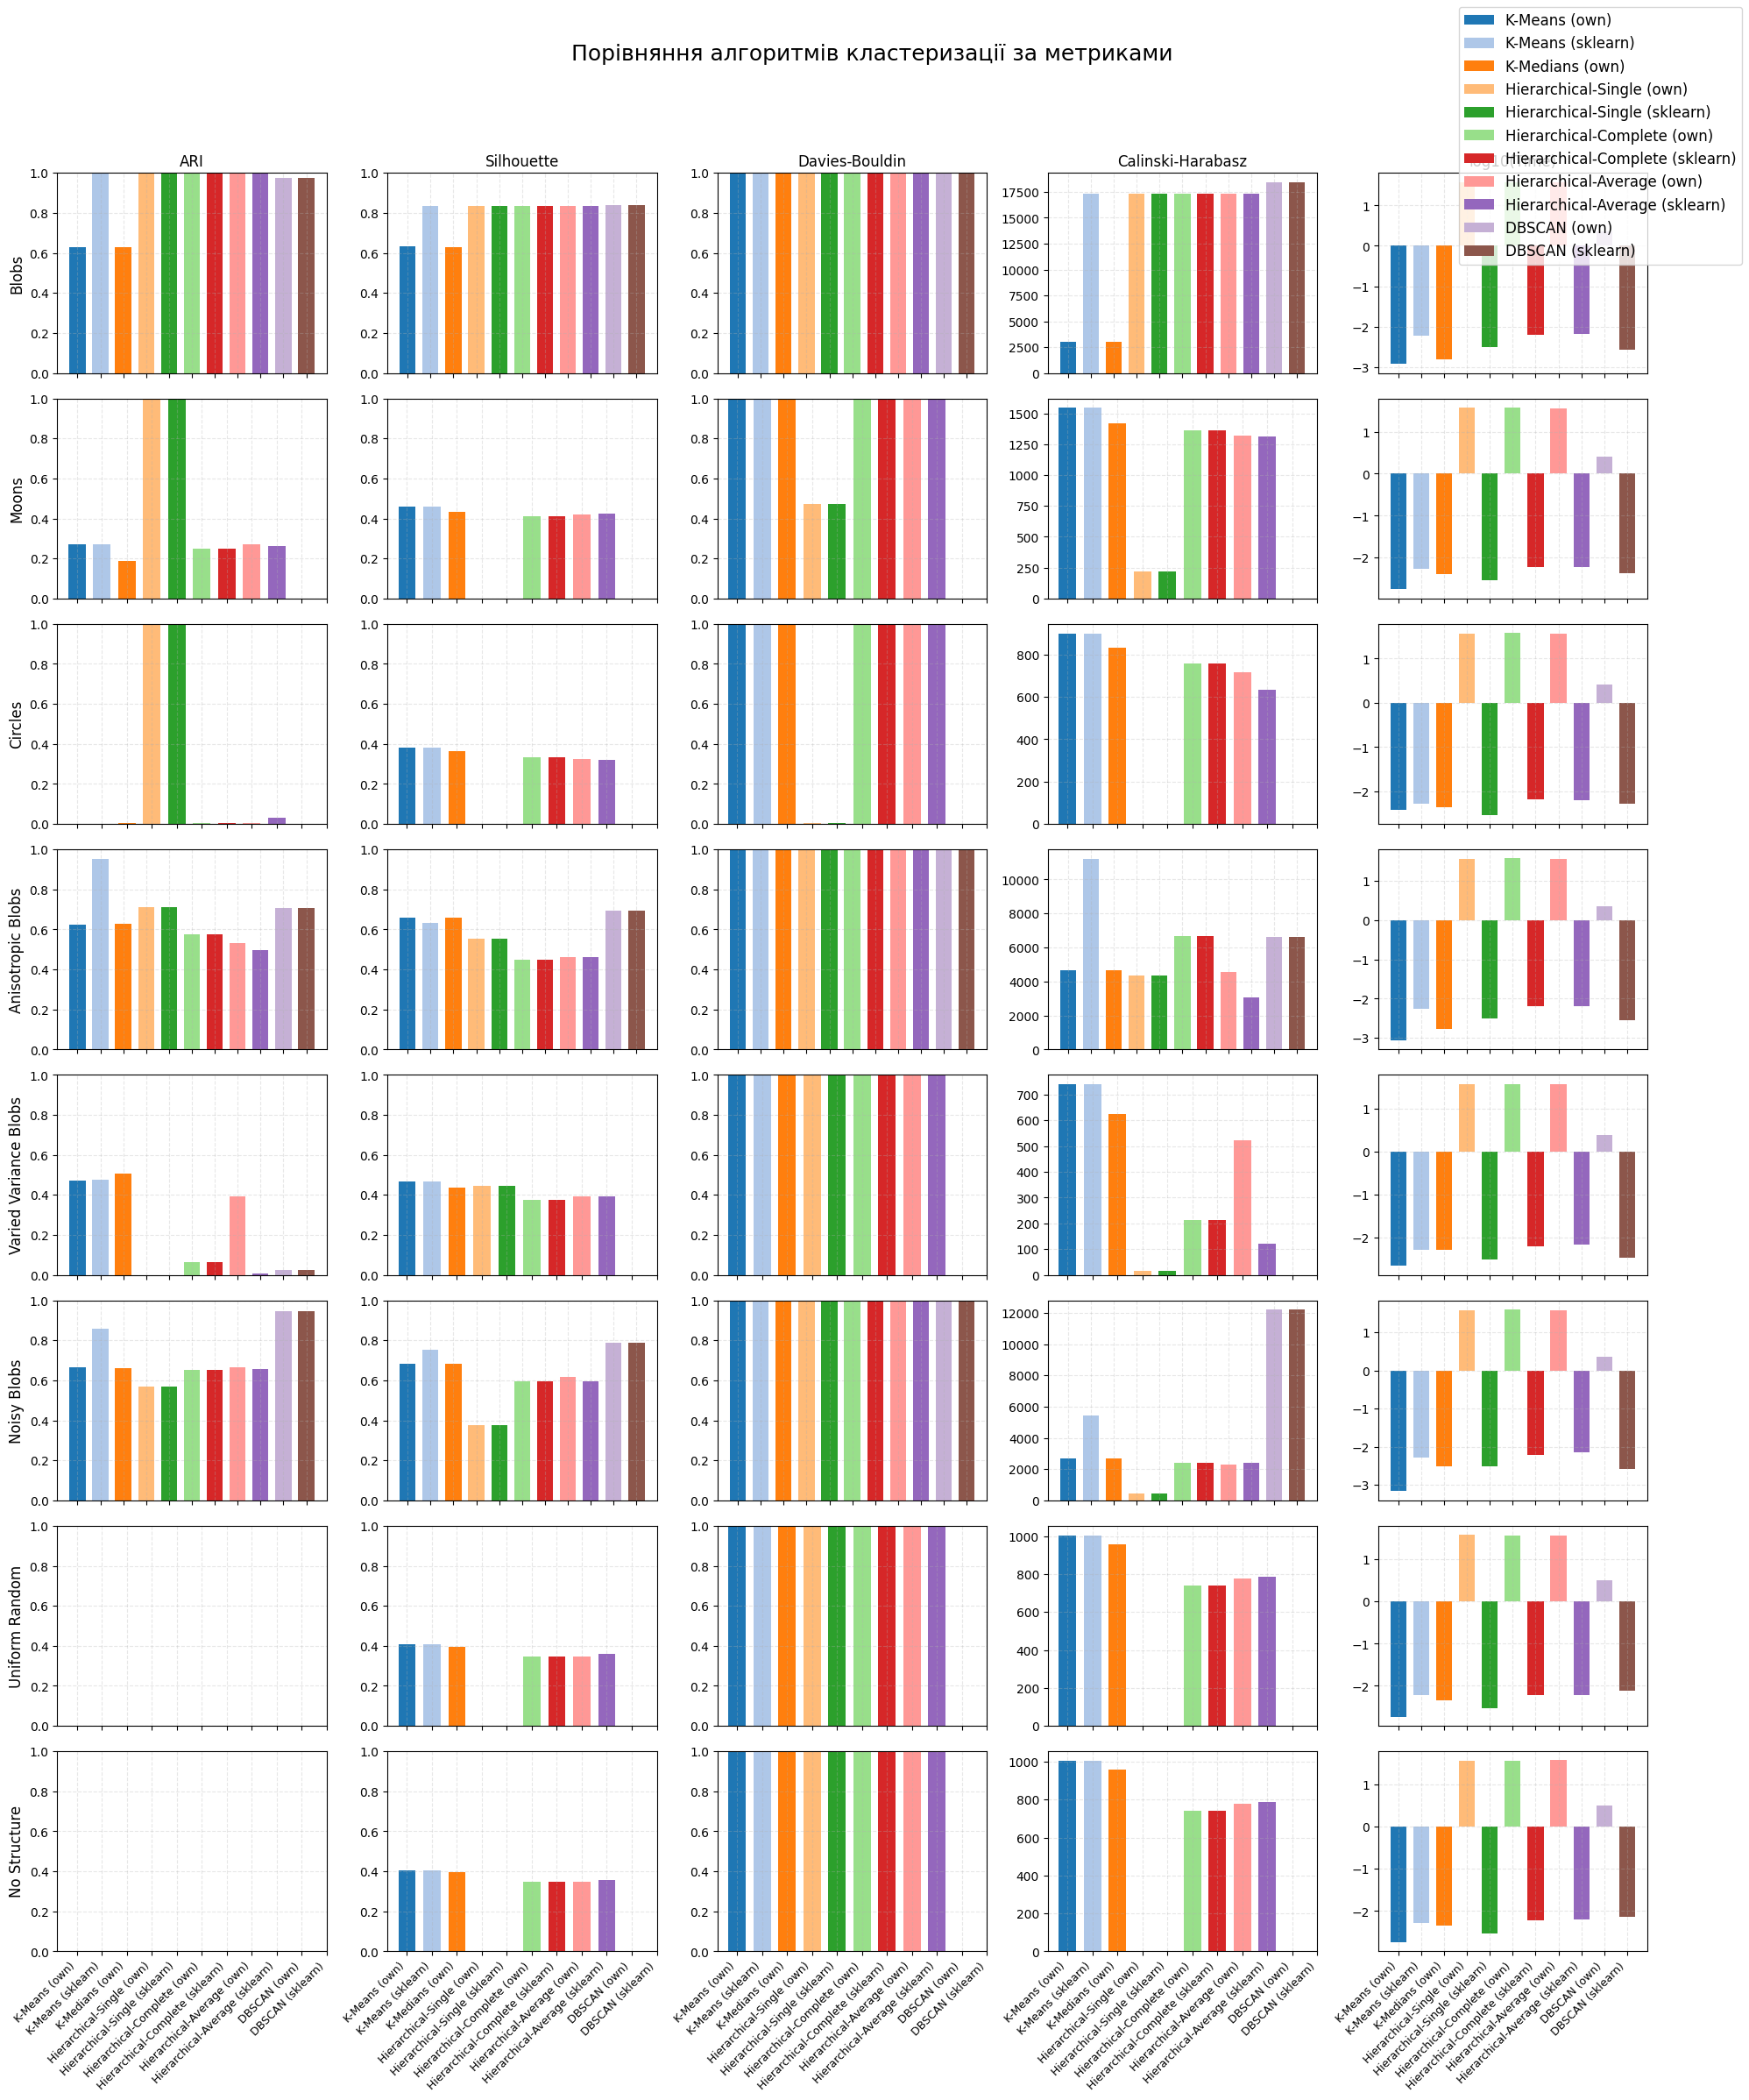

In [64]:
compare_and_plot_all(n_samples=1000, scale_factor=1.3)